In [1]:
%load_ext kedro.ipython
df = catalog.load("s3_conc_aligned_df")

[05/16/24 12:19:56] INFO     Registered line magic '%reload_kedro'                                   ]8;id=3446;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=478778;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py#51\51]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=618556;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=909302;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py#53\53]8;;\

                    INFO     Resolved project path as: /Users/gavinlou/Developer/gasai.             ]8;id=468371;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=29283;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py#164\164]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

24/05/16 12:19:58 WARN Utils: Your hostname, Gavins-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.241 instead (on interface en0)
24/05/16 12:19:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 12:19:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/16 12:19:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


[05/16/24 12:19:59] INFO     Kedro project gasAI                                                    ]8;id=227761;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=449506;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=377743;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=927205;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py#135\135]8;;\
                             'pipelines'                                                                           

[05/16/24 12:20:00] INFO     Registered line magic 'run_viz'                                        ]8;id=199812;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=645573;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/ipython/__init__.py#141\141]8;;\

                    INFO     Loading data from s3_conc_aligned_df (ParquetDataset)...           ]8;id=929017;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=538202;file:///Users/gavinlou/.pyenv/versions/3.10.13/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py#483\483]8;;\

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


# Check for missing values and handle them if necessary
df.fillna(df.mean(), inplace=True)

# Define the features and target
features = ['timestamp_bin', 'A1_Resistance']
target = 'resistance_ratio'

# Extract the feature matrix and target vector
X = df[features]
y = df[target]
groups = df['exp_no']

# Initialize the GroupShuffleSplit object for training/validation split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split into training and temporary (validation + testing) sets
train_idx, temp_idx = next(gss.split(X, y, groups=groups))

# Create DataFrames for training and temporary sets
train_df = df.iloc[train_idx]
temp_df = df.iloc[temp_idx]

# Split the temporary set into validation and testing sets
gss_temp = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss_temp.split(temp_df[features], temp_df[target], groups=temp_df['exp_no']))

# Create DataFrames for validation and testing sets
val_df = temp_df.iloc[val_idx]
test_df = temp_df.iloc[test_idx]

# Extract features and targets for each set
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Batch size definition
batch_size = 128

# Create Tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor.view(-1, 1))

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
for inputs, targets in train_loader:
    print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    print(f"Input type: {type(inputs)}, Target type: {type(targets)}")
    break  # Just checking the first batch



Inputs shape: torch.Size([128, 2]), Targets shape: torch.Size([128, 1])
Input type: <class 'torch.Tensor'>, Target type: <class 'torch.Tensor'>


In [4]:
def kl_divergence(rho, rho_hat):
    # Ensure sigmoid is applied correctly and mean does not reduce it to scalar
    rho_hat = torch.sigmoid(rho_hat)
    if rho_hat.dim() > 0:
        rho_hat = torch.mean(rho_hat, dim=0)
    else:
        rho_hat = rho_hat.unsqueeze(0)  # Adds a dimension if it's a scalar

    rho = torch.tensor([rho] * len(rho_hat), device=rho_hat.device)
    return torch.sum(rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat)))

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print(f"Fowards input type {type(x)}")
        # print(f"Fowards input shape {x.shape}")
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

input_size = 2  # Example for MNIST dataset, change as per your dataset
hidden_size = 128  # Size of hidden layers
latent_size = 128   # Size of the latent space representation

model = Autoencoder(input_size, hidden_size, latent_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, data_loader, epochs, rho, beta):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, _ in data_loader:  # Unpack the batch here
            optimizer.zero_grad()
            # print(f"Batch input type: {type(inputs)}")  # Check the type of inputs
            # print(f"Batch input shape: {inputs.shape}")
            outputs, latent_outputs = model(inputs)
            # print(f"Outputs shape: {outputs.shape}, Latent outputs shape: {latent_outputs.shape}")
            loss = criterion(outputs, inputs)
            kl_loss = kl_divergence(rho, latent_outputs)
            total_loss = loss + beta * kl_loss
            total_loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {total_loss.item()}')

# Parameters
rho = 0.05  # Target sparsity parameter
beta = 0.01  # Weight of the sparsity penalty term

train(model, train_loader, epochs=20, rho=rho, beta=beta)

Epoch 1, Loss: 0.5511482954025269
Epoch 2, Loss: 0.49252960085868835
Epoch 3, Loss: 0.5453920364379883
Epoch 4, Loss: 0.5465580821037292
Epoch 5, Loss: 0.7082335352897644
Epoch 6, Loss: 0.6452561616897583
Epoch 7, Loss: 0.5620478987693787
Epoch 8, Loss: 0.5354790687561035
Epoch 9, Loss: 0.4421108663082123
Epoch 10, Loss: 0.6270326375961304
Epoch 11, Loss: 0.5392063856124878
Epoch 12, Loss: 0.5507766604423523
Epoch 13, Loss: 0.6835042834281921
Epoch 14, Loss: 0.6983036994934082
Epoch 15, Loss: 0.4015863835811615
Epoch 16, Loss: 0.5333114862442017
Epoch 17, Loss: 0.6114388704299927
Epoch 18, Loss: 0.3037523627281189
Epoch 19, Loss: 0.5433733463287354
Epoch 20, Loss: 0.5806137323379517


# Learning Rate Scheduler

In [5]:
def lr_train(model, data_loader, epochs, rho, beta):
    model.train()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in data_loader:  # Correctly unpack the data (inputs) and targets
            optimizer.zero_grad()
            outputs, latent_outputs = model(data)  # Pass only the data (inputs) to the model
            loss = criterion(outputs, data)  # Compute loss using data (inputs)
            kl_loss = kl_divergence(rho, latent_outputs)
            total_loss = loss + beta * kl_loss
            total_loss.backward()
            optimizer.step()
        scheduler.step()  # Step the scheduler at the end of each epoch
        print(f'Epoch {epoch+1}, Loss: {total_loss.item()}')

# Parameters
lr_rho = 0.05  # Target sparsity parameter
lr_beta = 0.01  # Weight of the sparsity penalty term

lr_train(model, train_loader, epochs=20, rho=lr_rho, beta=lr_beta)


Epoch 1, Loss: 0.49222856760025024
Epoch 2, Loss: 0.6040196418762207
Epoch 3, Loss: 0.5772991180419922
Epoch 4, Loss: 0.663725733757019
Epoch 5, Loss: 0.5692221522331238
Epoch 6, Loss: 0.6473165154457092
Epoch 7, Loss: 0.5904619097709656
Epoch 8, Loss: 0.6689891815185547
Epoch 9, Loss: 0.48528236150741577
Epoch 10, Loss: 0.5426681041717529
Epoch 11, Loss: 0.4905341565608978
Epoch 12, Loss: 0.3640066385269165
Epoch 13, Loss: 0.46559396386146545
Epoch 14, Loss: 0.5614495277404785
Epoch 15, Loss: 0.5521577000617981
Epoch 16, Loss: 0.6440499424934387
Epoch 17, Loss: 0.4033474028110504
Epoch 18, Loss: 0.4391646385192871
Epoch 19, Loss: 0.39846071600914
Epoch 20, Loss: 0.4154316782951355


# K-mean Cluster

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
# Apply K-Means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_scaled)
df['cluster'] = kmeans.labels_

distances = kmeans.transform(df_scaled)
distance_features = pd.DataFrame(distances, columns=[f'distance_to_centroid_{i}' for i in range(k)])
df_cluster = pd.concat([df, distance_features], axis=1)

# write the df_cluster to parquet file
df_cluster.to_parquet("global_cluster_df.pq")

In [14]:
df_cluster.head()

,exp_no,timestamp_bin,A1_Resistance,A1_Resistance_diff,A1_Resistance_norm,A1_Sensor,A1_Sensor_diff,A1_Sensor_norm,SHT40_Humidity,SHT40_temp,index,resistance_ratio,ace_conc,expo_time,cluster,distance_to_centroid_0,distance_to_centroid_1,distance_to_centroid_2
0,0,0.0,720650.750,0.000,1.000000,4518.0,0.0,1.000000,42.835,29.430,4481.5,1.768473,3.033000e-07,3.0,2,6.547601,5.822474,3.891654
1,0,1.0,720361.875,0.000,0.999599,4519.5,0.0,1.000332,42.840,29.435,4483.5,1.768473,3.033000e-07,3.0,2,6.492225,5.761669,3.824894
2,0,2.0,719688.470,-673.405,0.998665,4523.0,3.5,1.001107,42.845,29.445,4485.5,1.768473,3.033000e-07,3.0,2,6.411652,5.589371,3.723517
3,0,3.0,719015.940,-1634.810,0.997731,4526.5,8.5,1.001881,42.830,29.435,4487.5,1.768473,3.033000e-07,3.0,2,6.584985,5.667950,3.932468
4,0,4.0,718727.905,-1345.095,0.997332,4528.0,7.0,1.002213,42.845,29.440,4489.5,1.768473,3.033000e-07,3.0,2,6.509793,5.615991,3.837188


# Grouping K-Cluster to look at experiments individually

# Hybrid Apporach in terms of grouping

In [7]:
from sklearn.cluster import KMeans

# Assuming df is your DataFrame
grouped = df.groupby('exp_no')

# Initialize lists to store centroids
centroids = []

for name, group in grouped:
    # Drop the 'exp_no' column and scale the features
    features = group.drop(columns=['exp_no'])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
    kmeans.fit(scaled_features)
    
    # Store the centroids
    centroids.append(kmeans.cluster_centers_)

# Convert centroids to a DataFrame for analysis
centroids_df = pd.DataFrame(np.vstack(centroids))

print(centroids_df.head())


         0         1         2         3         4         5         6   \
0 -0.483200 -1.268408  0.228468 -1.268408  1.259057 -0.253764  1.259057   
1  0.907404  0.604490  0.252571  0.604490 -0.616693 -0.167297 -0.616693   
2 -1.390735  0.643997 -0.989341  0.643997 -0.598995  0.825273 -0.598995   
3 -0.553547 -1.362613  0.130734 -1.362613  1.382080 -0.145326  1.382080   
4  0.848906  0.524676  0.279642  0.524676 -0.562503 -0.196051 -0.562503   

         7         8         9             10            11   12  
0 -0.141226  0.791221 -0.483200 -4.440892e-16 -5.293956e-23  0.0  
1 -0.411942 -0.106628  0.907404 -4.440892e-16 -5.293956e-23  0.0  
2  1.229659 -1.055175 -1.390735 -4.440892e-16 -5.293956e-23  0.0  
3 -0.255068 -0.467714 -0.553547 -2.220446e-16 -5.293956e-23  0.0  
4 -0.359794  0.682020  0.848906 -2.220446e-16 -5.293956e-23  0.0  


In [8]:
# Initialize lists to store results
cluster_labels = []
centroids = []

# Group by 'exp_no'
grouped = df.groupby('exp_no')

for name, group in grouped:
    # Drop the 'exp_no' column and scale the features
    features = group.drop(columns=['exp_no'])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
    labels = kmeans.fit_predict(scaled_features)
    
    # Add the cluster labels to the group
    group['cluster'] = labels
    cluster_labels.append(group)
    
    # Store the centroids
    centroids.append(kmeans.cluster_centers_)

# Concatenate the results into a single DataFrame
df_with_clusters = pd.concat(cluster_labels)

# Optionally, convert centroids to a DataFrame for further analysis
centroids_df = pd.DataFrame(np.vstack(centroids))

# Display the DataFrame with cluster labels
print(df_with_clusters)

        exp_no  timestamp_bin  A1_Resistance  A1_Resistance_diff  \
0            0            0.0     720650.750               0.000   
1            0            1.0     720361.875               0.000   
2            0            2.0     719688.470            -673.405   
3            0            3.0     719015.940           -1634.810   
4            0            4.0     718727.905           -1345.095   
...        ...            ...            ...                 ...   
469990     272         1859.0    1786303.310           -2385.810   
469991     272         1860.0    1785826.870           -1429.880   
469992     272         1861.0    1786779.750            -477.000   
469993     272         1862.0    1787733.750            1906.880   
469994     272         1863.0    1790124.495            3821.185   

        A1_Resistance_norm  A1_Sensor  A1_Sensor_diff  A1_Sensor_norm  \
0                 1.000000     4518.0             0.0        1.000000   
1                 0.999599     4519.5

In [11]:
df_with_clusters.head()
# df_with_clusters.to_parquet("cluster_conc_aligned_df.pq")

,exp_no,timestamp_bin,A1_Resistance,A1_Resistance_diff,A1_Resistance_norm,A1_Sensor,A1_Sensor_diff,A1_Sensor_norm,SHT40_Humidity,SHT40_temp,index,resistance_ratio,ace_conc,expo_time,cluster
0,0,0.0,720650.750,0.000,1.000000,4518.0,0.0,1.000000,42.835,29.430,4481.5,1.768473,3.033000e-07,3.0,2
1,0,1.0,720361.875,0.000,0.999599,4519.5,0.0,1.000332,42.840,29.435,4483.5,1.768473,3.033000e-07,3.0,2
2,0,2.0,719688.470,-673.405,0.998665,4523.0,3.5,1.001107,42.845,29.445,4485.5,1.768473,3.033000e-07,3.0,2
3,0,3.0,719015.940,-1634.810,0.997731,4526.5,8.5,1.001881,42.830,29.435,4487.5,1.768473,3.033000e-07,3.0,2
4,0,4.0,718727.905,-1345.095,0.997332,4528.0,7.0,1.002213,42.845,29.440,4489.5,1.768473,3.033000e-07,3.0,2


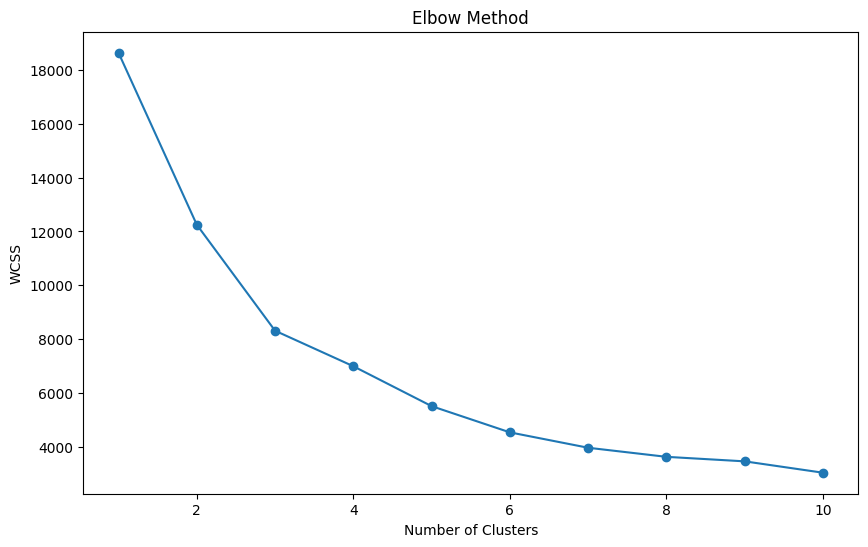

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate WCSS for different number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to visualize the Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()
